In [47]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split,ConcatDataset
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import json
import cv2
from PIL import Image
from model import SimpleCNN

# 0. Cấu hình chung

In [48]:
dataset_dir = 'dataset_sieucappro_rembg'
train_dir   = os.path.join(dataset_dir, 'train')
test_dir    = os.path.join(dataset_dir, 'test')
batch_size  = 32
device       = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


#  1. Data Transforms & Augmentation 

In [49]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),      # lật ngang
    transforms.RandomRotation(15),         # xoay ±15°
    transforms.ColorJitter(
        brightness=0.3, contrast=0.3, saturation=0.3
    ),                                     # chỉnh sáng, tương phản, bão hòa
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

eval_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#  2. Dataset & Dataloader 

In [50]:
full_train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset       = ImageFolder(root=test_dir, transform=eval_transform)

+ Split train/validation

In [51]:
train_size = int(0.9 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

+ Đảm bảo val dùng eval_transform

In [52]:
val_dataset.dataset.transform = eval_transform
val_dataset = ConcatDataset([val_dataset, test_dataset])

# Lấy danh sách tên lớp
class_names = full_train_dataset.classes
num_classes = len(class_names)

print(f"Found {num_classes} classes: {class_names}")

Found 26 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


+ lưu class names

In [53]:
with open('sign_language_web/class_names.json','w', encoding='utf-8') as f:
    json.dump(class_names, f, ensure_ascii=False)

In [54]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4)

# 3. Model Definition (CNN with BatchNorm)

+ Khởi tạo model CNN

In [55]:
model = SimpleCNN(num_classes).to(device)

In [56]:
# Nếu muốn dùng ResNet18 pretrained, bỏ comment khối này và comment CNN trên:
# model = resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, num_classes)
# model = model.to(device)


# 4. Loss, Optimizer, Scheduler 

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

# 5. Training Loop

In [58]:
epochs = 5
train_acc_history = []
val_acc_history   = []

for epoch in range(1, epochs+1):
    model.train()
    correct, total = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss    = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total   += labels.size(0)
    train_acc = correct/total
    train_acc_history.append(train_acc)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs,1)
            correct += (preds==labels).sum().item()
            total   += labels.size(0)
    val_acc = correct/total
    val_acc_history.append(val_acc)

    # Step scheduler
    scheduler.step(val_acc)
    print(f"Epoch {epoch}/{epochs} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Lưu model sau train cơ bản
os.makedirs('sign_language_web', exist_ok=True)
torch.save(model.state_dict(), 'sign_language_web/sign_language_model_cnn.pth')
print("Model saved to sign_language_web/sign_language_model_cnn.pth")


Epoch 1/5 - Train Acc: 0.8265, Val Acc: 0.9113
Epoch 2/5 - Train Acc: 0.9272, Val Acc: 0.9131
Epoch 3/5 - Train Acc: 0.9486, Val Acc: 0.9364
Epoch 4/5 - Train Acc: 0.9591, Val Acc: 0.9448
Epoch 5/5 - Train Acc: 0.9676, Val Acc: 0.9505
Model saved to sign_language_web/sign_language_model_cnn.pth


# 6. Đánh giá trên Test Set

In [59]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total   += labels.size(0)
print(f"Test Accuracy: {correct/total:.4f}")

Test Accuracy: 0.1498


# 7. Vẽ biểu đồ Accuracy 

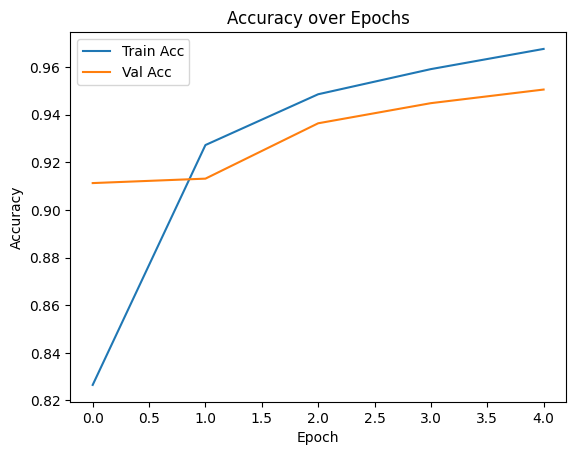

In [60]:
plt.figure()
plt.plot(train_acc_history, label='Train Acc')
plt.plot(val_acc_history,   label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()


In [61]:
# Đánh giá mô hình trên tập test
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\n✅ Test Accuracy: {test_acc:.4f}")



✅ Test Accuracy: 0.1498


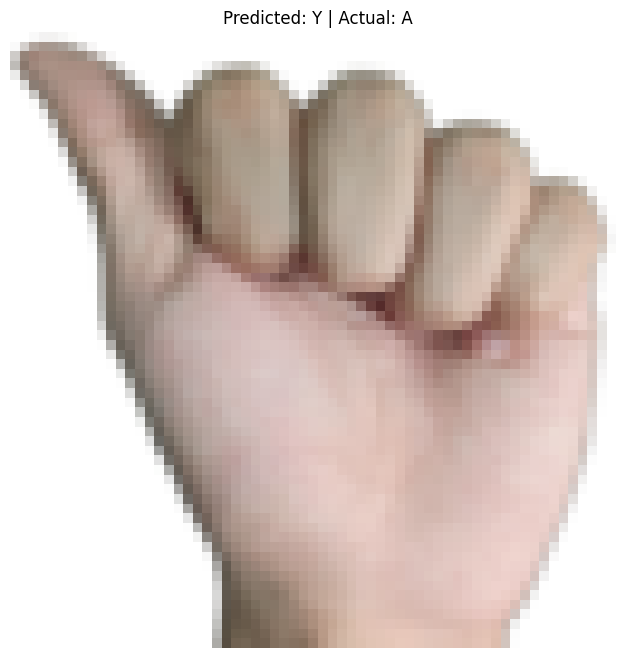

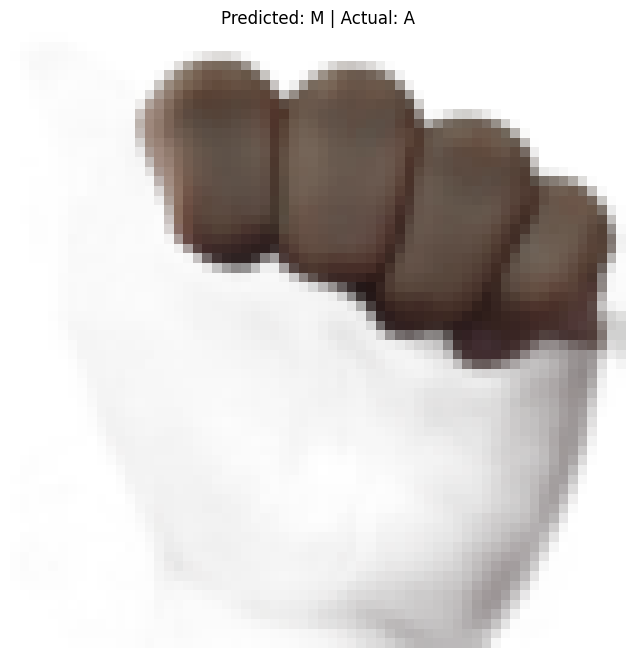

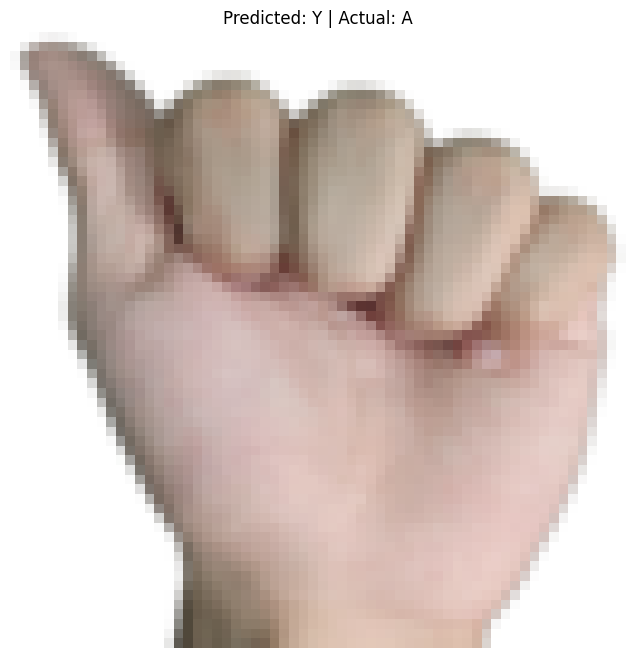

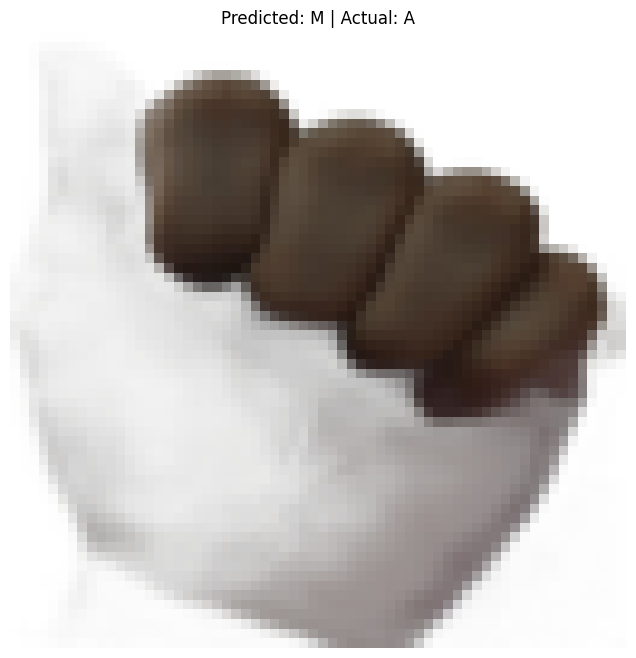

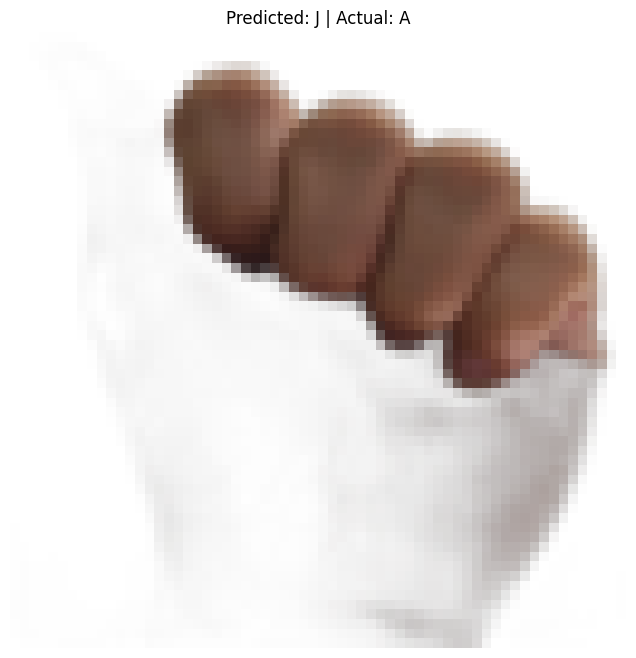

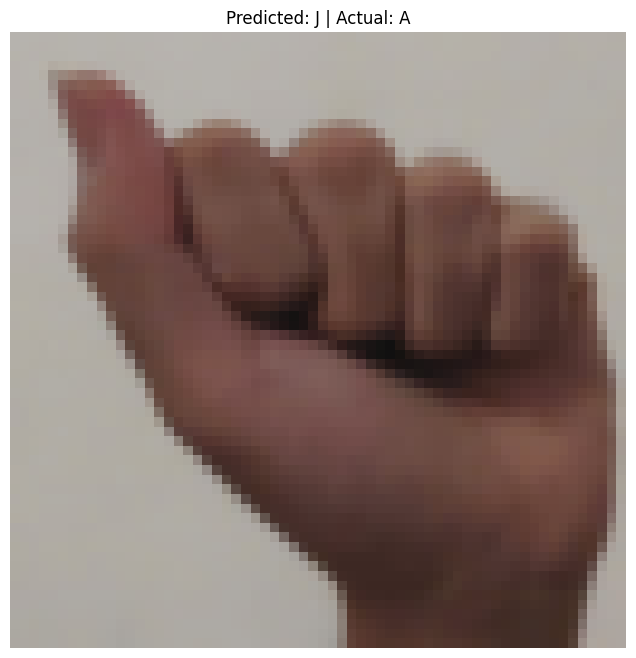

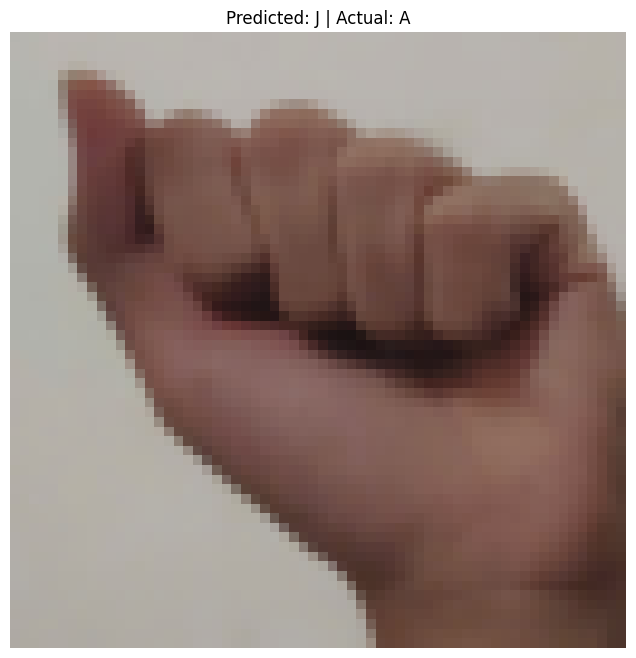

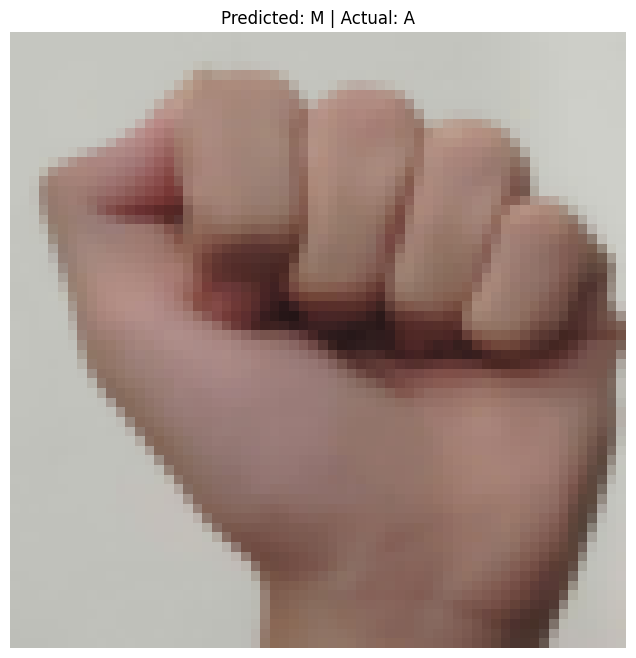

In [62]:
# Hiển thị một số ảnh từ tập test cùng nhãn dự đoán
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Lấy một batch ảnh từ test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Dự đoán
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Hiển thị 8 ảnh đầu tiên với nhãn dự đoán
for i in range(8):
    imshow(images[i], f"Predicted: {class_names[predicted[i]]} | Actual: {class_names[labels[i]]}")


Tổng số ảnh dự đoán sai: 210


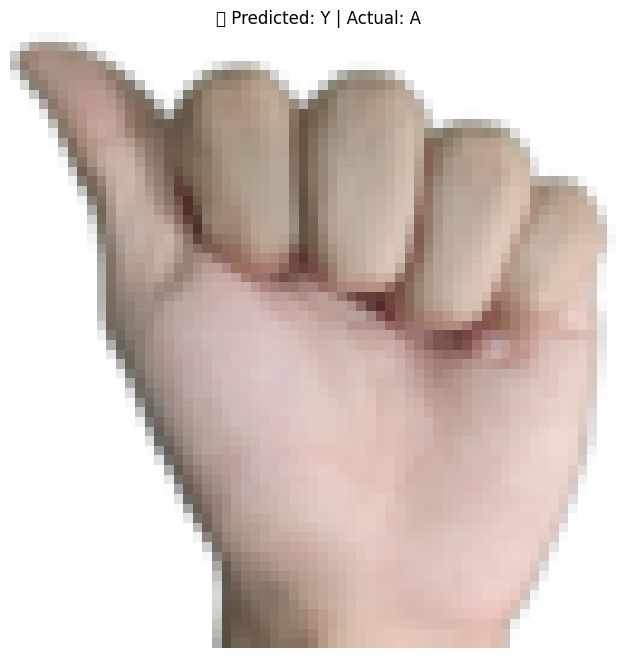

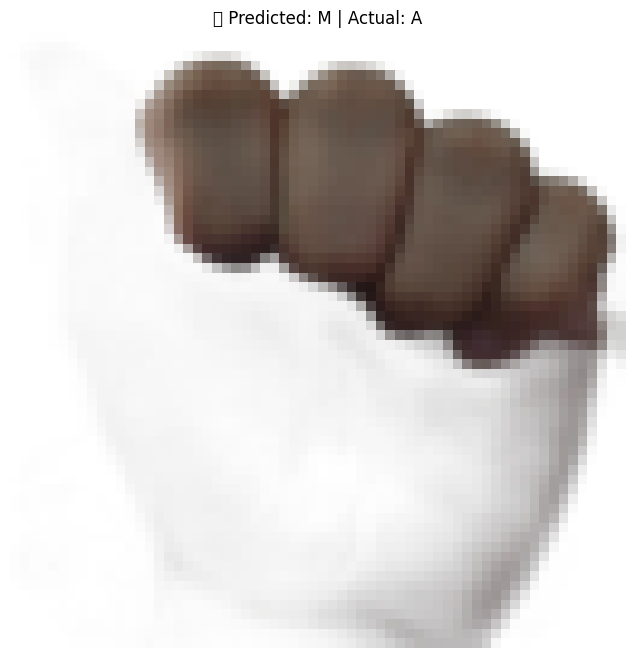

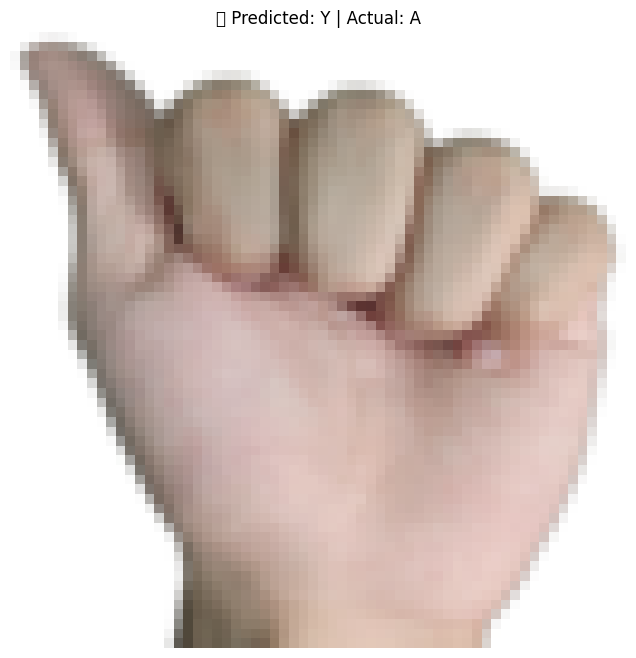

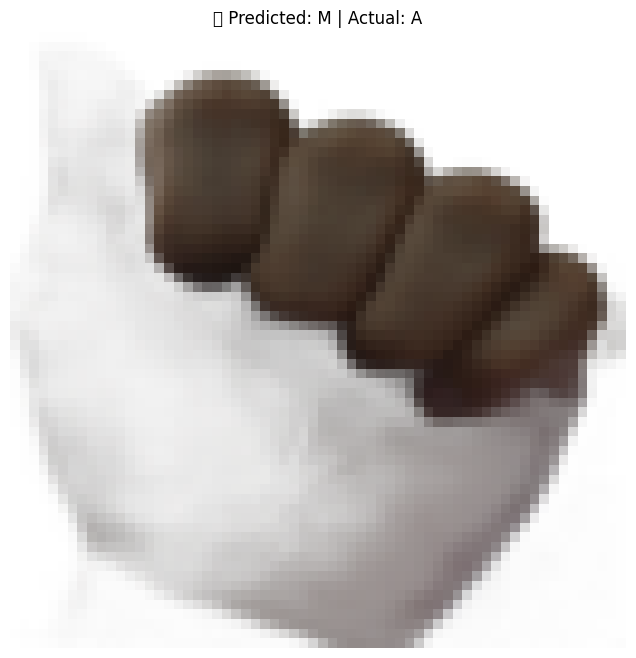

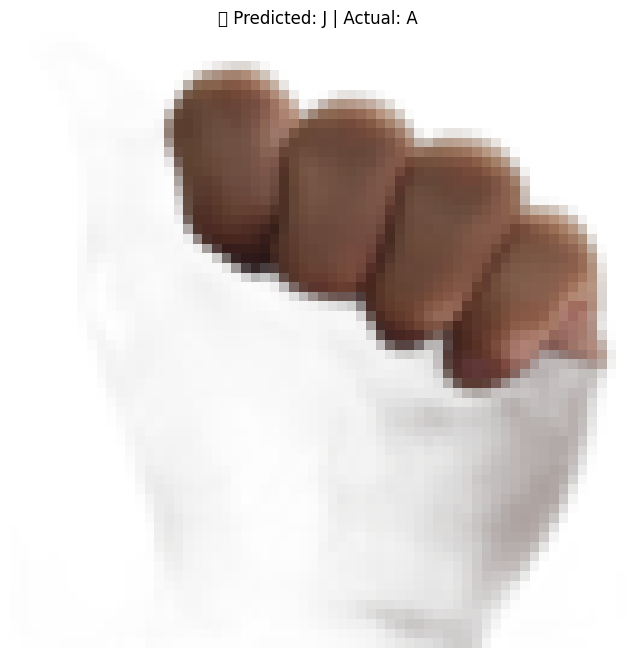

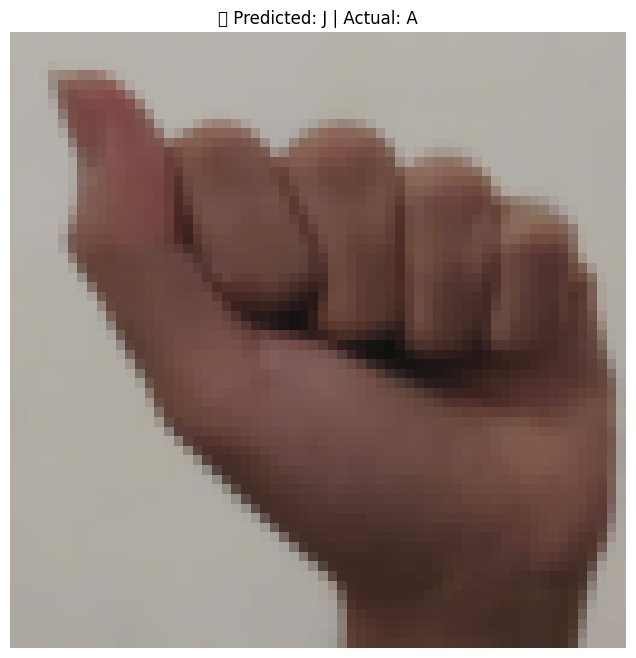

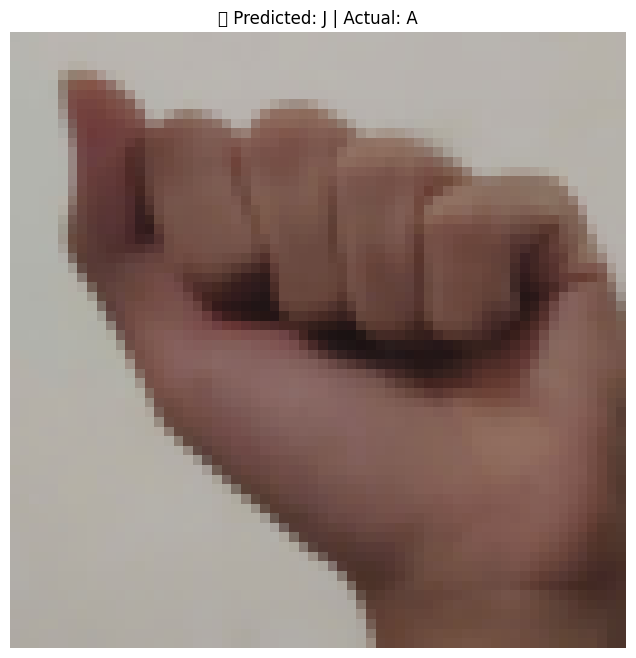

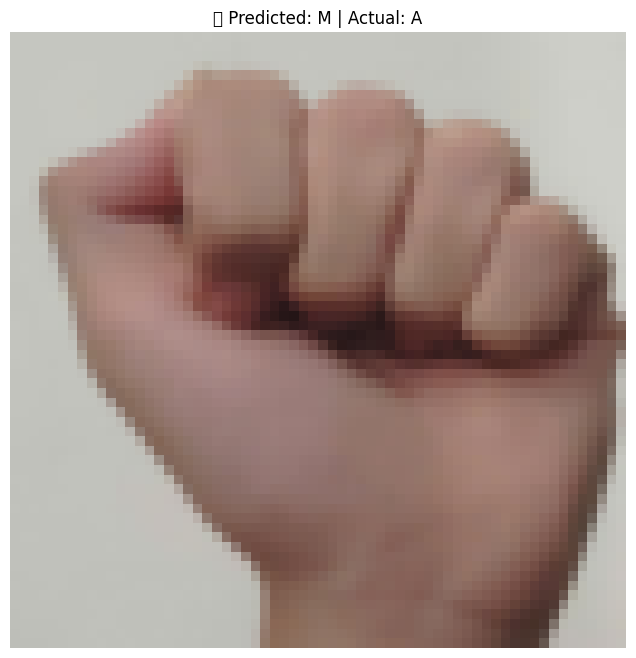

In [63]:
# Hiển thị các ảnh mà mô hình dự đoán sai
wrong_preds = []

# Lặp qua toàn bộ test_loader để tìm ảnh sai
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(len(labels)):
            if preds[i] != labels[i]:
                wrong_preds.append((images[i], preds[i], labels[i]))

# Hiển thị tối đa 8 ảnh sai
print(f"Tổng số ảnh dự đoán sai: {len(wrong_preds)}")
for i in range(min(8, len(wrong_preds))):
    img, pred_label, true_label = wrong_preds[i]
    imshow(img, f"❌ Predicted: {class_names[pred_label]} | Actual: {class_names[true_label]}")
